In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.nn import Parameter

torch.set_default_tensor_type('torch.cuda.FloatTensor')

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from torch.autograd import Variable
from IPython.display import clear_output

get_ipython().run_line_magic('pylab', 'inline')

Populating the interactive namespace from numpy and matplotlib


In [2]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [3]:
class ModuleWrapper(nn.Module):
    """Wrapper for nn.Module with support for arbitrary flags and a universal forward pass"""

    def __init__(self):
        super(ModuleWrapper, self).__init__()

    def set_flag(self, flag_name, value):
        setattr(self, flag_name, value)
        for m in self.children():
            if hasattr(m, 'set_flag'):
                m.set_flag(flag_name, value)

    def forward(self, x):
        for module in self.children():
            x = module(x)
        return x


class LinearVariance(ModuleWrapper):
    def __init__(self, in_features, out_features, bias=True):
        super(LinearVariance, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        #Your parameter is sigma, for standard deviation
        self.sigma = Parameter(torch.Tensor(out_features, in_features))
        #and bias, if option is true (default)
        if bias:
            self.bias = Parameter(torch.Tensor(1, out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.sigma.size(1))
        self.sigma.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

    def forward(self, x):
        lrt_mean = self.bias
        lrt_std = torch.sqrt_(1e-16 + F.linear(x * x, self.sigma * self.sigma))
        #this is epsilon (unit normal gaussian)
        eps = Variable(lrt_std.data.new(lrt_std.size()).normal_())
        return lrt_mean + eps * lrt_std

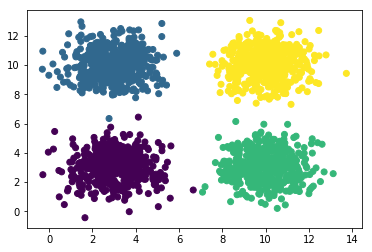

In [4]:
def get_data(means, variance=[[1, 0], [0, 1]], n=500):
    xs, ys = [], []
    
    #random multivariate normal distributions with expected values
    for c, mean in enumerate(means):
        x, y = np.random.multivariate_normal(mean, variance, n).T
        data, labels = np.array(list(zip(x, y))), np.zeros(n)+c
        xs.append(data)
        ys.append(labels)
        
    #asbatch
    X, y = np.vstack(xs).astype(float32),  np.hstack(ys).astype(long)

    return X, y

#These are your classes: 
Xtr, ytr = get_data([[3, 3], [3, 10], [10, 3], [10, 10]])
Xte, yte = get_data([[3, 3], [3, 10], [10, 3], [10, 10]])
pylab.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr)

In [5]:
'''
#two inputs...
the_layer = LinearVariance(100, 2)

model = torch.nn.Sequential(
  torch.nn.Linear(2, 100),
  torch.nn.LeakyReLU(),
    
#fully connected layers
  torch.nn.Linear(100, 100),
  torch.nn.LeakyReLU(),
    
  torch.nn.Linear(100, 100),
  torch.nn.LeakyReLU(),
    
  torch.nn.Linear(100, 100),
  torch.nn.LeakyReLU(),
  
#And our 'variance' layer, two neurons
  the_layer,
  torch.nn.LeakyReLU(),
  
#One more fully connected...
  torch.nn.Linear(2, 100),
  torch.nn.LeakyReLU(),
  
#And softmax output to four classes
  torch.nn.Linear(100, 4),
  torch.nn.Softmax()
)
'''

"\n#two inputs...\nthe_layer = LinearVariance(100, 2)\n\nmodel = torch.nn.Sequential(\n  torch.nn.Linear(2, 100),\n  torch.nn.LeakyReLU(),\n    \n#fully connected layers\n  torch.nn.Linear(100, 100),\n  torch.nn.LeakyReLU(),\n    \n  torch.nn.Linear(100, 100),\n  torch.nn.LeakyReLU(),\n    \n  torch.nn.Linear(100, 100),\n  torch.nn.LeakyReLU(),\n  \n#And our 'variance' layer, two neurons\n  the_layer,\n  torch.nn.LeakyReLU(),\n  \n#One more fully connected...\n  torch.nn.Linear(2, 100),\n  torch.nn.LeakyReLU(),\n  \n#And softmax output to four classes\n  torch.nn.Linear(100, 4),\n  torch.nn.Softmax()\n)\n"

In [6]:
class ToyModel(torch.nn.Module):
    def __init__(self):
        super(ToyModel, self).__init__()
        self.linear1 = torch.nn.Linear(2, 100)
        self.linear2 = torch.nn.Linear(100, 100)
        self.linear3 = torch.nn.Linear(100, 100)
        self.linear4 = torch.nn.Linear(100, 100)
        self.linvar = LinearVariance(100, 2)
        self.linear5 = torch.nn.Linear(2, 100)
        self.output = torch.nn.Linear(100, 4)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.nn.LeakyReLU()(x)
        x = self.linear2(x)
        x = torch.nn.LeakyReLU()(x)
        x = self.linear3(x)
        x = torch.nn.LeakyReLU()(x)
        x = self.linear4(x)
        x = torch.nn.LeakyReLU()(x)
        act = self.linvar(x)
        x = torch.nn.LeakyReLU()(act)
        x = self.linear5(x)
        x = torch.nn.LeakyReLU()(x)
        x = self.output(x)
        output = torch.nn.Softmax()(x)
        return output, act
    
model = ToyModel()

In [7]:
loss_fn = torch.nn.CrossEntropyLoss(size_average=True)

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

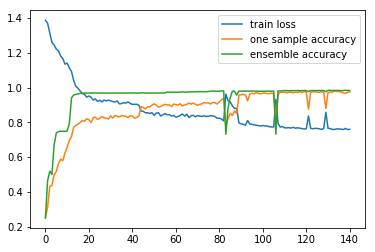

iter 14000: loss_train = 0.760 acc_test_one_sampl = 0.976 acc_test_ens = 0.983


In [9]:
import matplotlib.pyplot as plt

def plot_me(tr_loss, one_sample, ensemble):
    """Plots optimization."""
    plt.plot(tr_loss, label='train loss')
    plt.plot(one_sample, label='one sample accuracy')
    plt.plot(ensemble, label='ensemble accuracy')
    plt.legend();
    plt.show();

tr_loss = []
one_sample = []
ensemble = []

for t in range(50000):
    y_pred, _ = model(Variable(torch.from_numpy(Xtr)).cuda())
    y_true = Variable(torch.from_numpy(ytr)).long().cuda()
    loss = loss_fn(y_pred, y_true)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % 100 == 0:
        y_test_sam, _ = model(Variable(torch.from_numpy(Xte)).cuda())
        
        y_test_ens, _ = model(Variable(torch.from_numpy(Xte)).cuda())
        for i in range(100):
            add, _ = model(Variable(torch.from_numpy(Xte)).cuda())
            y_test_ens += add
        y_test_ens /= 101.
        
        loss = loss.item()
        acc_sam =  np.mean(y_test_sam.argmax(1).cpu().numpy() == yte)
        acc_ens = np.mean(y_test_ens.argmax(1).cpu().numpy() == yte)
        tr_loss.append(loss)
        one_sample.append(acc_sam)
        ensemble.append(acc_ens)
        te_acc = []
        if t % 1000 == 0:
            clear_output()
            plot_me(tr_loss, one_sample, ensemble)
            print('iter %s:' % t, 
                  'loss_train = %.3f' % loss, 
                  'acc_test_one_sampl = %.3f' % acc_sam,
                  'acc_test_ens = %.3f' % acc_ens)
            if loss < .76:
                break

/home/ubuntu/anaconda3/envs/mklear/lib/python3.6/site-packages/ipykernel/__main__.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


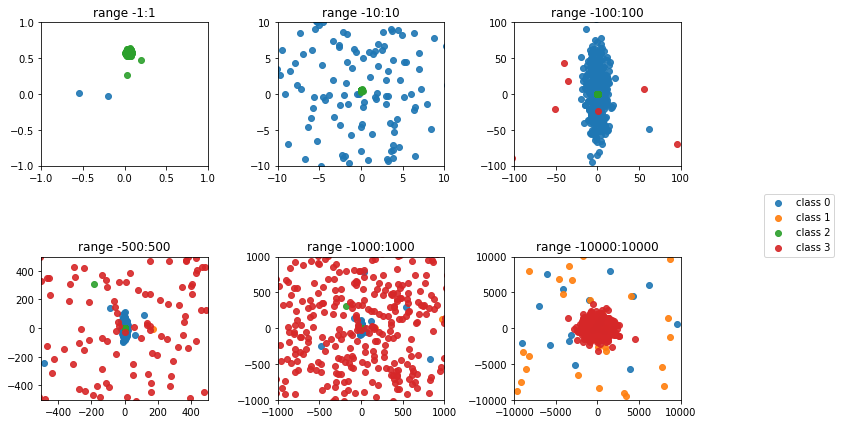

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

with torch.no_grad():
    for cls in np.unique(yte):
        indcs = np.where(yte==cls)
        X = Xte[indcs]
        _, acts = model(torch.from_numpy(X).cuda())
        acts = acts.cpu().numpy()
        x = acts[:, 0]
        y = acts[:, 1]
        bins = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)]
        lims = [1, 10, 100, 500, 1000, 10000]
        for i, lim in enumerate(lims):
            k, j = bins[i]
            axs[k, j].scatter(x, y, label='class {}'.format(cls), alpha=.9)
            axs[k, j].set_xlim(-lim, lim)
            axs[k, j].set_ylim(-lim, lim)
            if cls == len(np.unique(yte))-1:
                axs[k, j].set_title('range {}:{}'.format(-lim, lim))



plt.legend(loc=(1.5, 1))
plt.tight_layout()
plt.show()

In [14]:
ytr.shape

(2000,)